# An invitation to compressive learning
In this notebook, we highlight the potential gain of compressive learning on a large-scale  synthetic dataset. 

**Warning:** It takes a little while to run.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from time import time as time

# We import the pycle toolbox for sketched learning; we will need three submodules
import pycle
from pycle import sketching, compressive_learning, utils

# Fix the random seed for reproducibility
np.random.seed(0)

Let's start by generating our example dataset from a Gaussian mixture model. It will be large-scale, constited of $10^7$ examples in dimension 20, drawn from a Gaussian mixture model with $10$ Gaussian modes. 

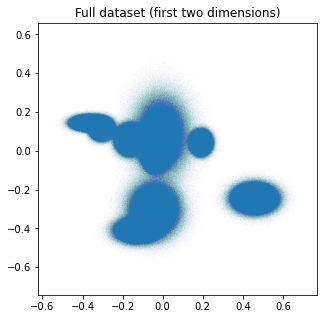

In [2]:
d = 20       # Dimension
K = 10       # Number of Gaussians
n = int(1e7) # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
X = pycle.utils.generatedataset_GMM(d,K,n,
                                    normalize = 'l_inf-unit-ball',
                                    balanced = False, 
                                    separation_scale = 6) 

# Bounds on the dataset, necessary for compressive k-means
bounds = np.array([-np.ones(d),np.ones(d)]) # We assumed the data is normalized between -1 and 1

# Visualize the dataset
plt.figure(figsize=(5,5))
plt.title("Full dataset (first two dimensions)")
plt.scatter(X[:,0],X[:,1],s=0.1, alpha=0.01)
plt.show()

We first compress the dataset as a single sketch vector of length $m = 8Kd = 1600$.

In [3]:
# Pick the dimension m (5*K*d is usually (just) enough for clustering)
m = 8*K*d 

# Kernel bandwith (squared)
sigma2 = 0.1

# We want m Gaussian frequencies in dimension d, with squared kernel bandwith sigma2
W = pycle.sketching.drawFrequencies("FG",d,m,sigma2)

# To generate the map, we provide a nonlinearity rho (here complex exponential for RFF) and the projections W
Phi = pycle.sketching.SimpleFeatureMap("ComplexExponential",W)

# We sketch X with Phi: we map a 10000000x20 dataset -> a 1600-dimensional complex vector
z = pycle.sketching.computeSketch(X,Phi,batch_size=5)


print("Dataset size: ", X.shape)
print("Sketch size:  ", z.shape)

print("Relative size (\"data compression ratio\"): ", X.size/z.size)


Dataset size:  (10000000, 20)
Sketch size:   (1600,)
Relative size ("data compression ratio"):  125000.0


Now, to solve k-means (with $10$ centroids) from this sketch, we call the CLOMPR algorithm [1]. To get a rough idea of the computational advantage of sketching, we record the elapsed time. We also compare to the standard k-means implementation from the `scikit-learn` library.

> [1] Nicolas Keriven, Anthony Bourrier, Rémi Gribonval, Patrick Pérez, "Sketching for Large-Scale Learning of Mixture Models", Information and Inference: a Journal of the IMA, vol. 7, issue 3, pp. 447-508, 2018 [ArXiv](https://arxiv.org/abs/1606.02838).

In [4]:
start = time()
(weights,centroids) = pycle.compressive_learning.CLOMPR("k-means",
                                                        z,Phi,K,
                                                        bounds,nRepetitions=1)
stop = time()
print(f"Time to learn centroids from the sketch : {stop-start:.2f} seconds")

Time to learn centroids from the sketch : 19.87 seconds


In [5]:
from sklearn.cluster import KMeans
kmeans_estimator = KMeans(n_clusters=K)

start = time()
kmeans_estimator.fit(X)
stop = time()
print(f"Time to learn centroids from the full dataset : {stop-start:.2f} seconds")

Time to learn centroids from the full dataset : 291.58 seconds


Let's compare the performances, as expressed by the Sum of Squared Errors (SSE), of both approaches. 

What is the "price to pay" for sketching?

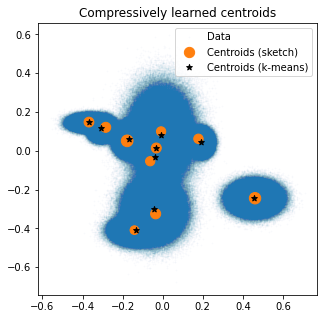

SSE from sketch: 615246.32
SSE from k-means: 591302.73
Relative SSE (SSE of usual k-means / SSE of the centroids recovered from the sketch): 1.04


In [9]:
# Visualize the centroids (we re-use the dataset for visual comparison)
plt.figure(figsize=(5,5))
plt.title("Compressively learned centroids")
plt.scatter(X[:,0],X[:,1],s=1, alpha=0.015, label="Data")
plt.scatter(centroids[:,0],centroids[:,1],s=1000*weights, label="Centroids (sketch)")

# For comparison, draw little red stars for Kmeans centroid
centroids_kmeans = kmeans_estimator.cluster_centers_
plt.scatter(centroids_kmeans[:,0], centroids_kmeans[:,1], marker='*', c='k', label="Centroids (k-means)")

plt.legend(loc = 'upper right')
plt.show()

SSE_sketching = pycle.utils.SSE(X,centroids)
print(f"SSE from sketch: {SSE_sketching:.2f}")

# Compare to k-means
SSE_kmeans = pycle.utils.SSE(X,centroids_kmeans)
print(f"SSE from k-means: {SSE_kmeans:.2f}")

print(f"Relative SSE (SSE of usual k-means / SSE of the centroids recovered from the sketch): {SSE_sketching/SSE_kmeans:.2f}")


### Conclusion
In this notebook, we gave an example where sketching can bring substantial memory and time savings, while still allowing clustering performances relatively comparable to the uncompressed `k-means` algorithm.

Some words of caution: in our time analysis, note that we did not include the time required to compute the sketch itself, so the comparison is not completely honest. However, computation of the sketch could be very easily parallelized (not done here), which would heavily reduce this time. Moreover, our code for sketched learning is not at all optimized for running speed (compared to such a popular library such as `scikit-learn`). The time advantages of sketched learning would continue to increase as the size of the dataset increases.